### Classificaton Models

In this workbook, we will focus on feature creations to fit two classification models (Xgboost and Random Forest) and one linear model (Ridge) 
<br>

Based on the exploratory analysis, the following features were identified:
- month
- dayofweek
- product category
- shop id

However, the test set for the submission is asking us to submit at monthly level, so the dayofweek and holiday features would not be applicable. We left with month, product category and shop id.

From the time series analysis, we do observe seasonality for the sale pattern, hence lag features would be useful too.

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance
import matplotlib.pyplot as plt
import holidays
import seaborn as sns
from sklearn import linear_model
sns.set()
%matplotlib inline 

C:\Users\sit_k\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
raw_df = pd.read_csv('data/train_df.csv', parse_dates=['date'])
# outlier removal steps as identified in exploratory analysis
id_out = [11, 14, 15, 12]
raw_df.loc[(raw_df.date == '2013-11-29') & (raw_df.item_category_id.isin(id_out)), 'sales'] = np.nan
raw_df.loc[(raw_df.date_block_num == 10) & (raw_df.item_category_id.isin(id_out))].interpolate(method='linear');

In [3]:
raw_df.shape

(2916104, 11)

#### Convert daily dataframe info monthly

In [4]:
raw_df['month'] = raw_df['date'].dt.month

In [5]:
month_df = raw_df.groupby(['date_block_num', 'shop_id', 'item_id','item_category_id','month']).agg({'item_cnt_day':'sum', 'item_price':'mean'}).reset_index()

In [6]:
# create two helper columns, shop_item and shop_item_date_block_num ('helper'), which will be used for data imputation
month_df['shop_item'] = month_df['item_id'].astype('str') + '_' + month_df['shop_id'].astype('str')
month_df['helper'] = month_df['item_id'].astype('str') + '_' + month_df['shop_id'].astype('str') + '_' +month_df['date_block_num'].astype('str')

##### Imputing records to ensure all sku/shop have 33 periods of data

In [7]:
# these are tempoarily table to be used to refill values for missing records
item = pd.read_csv('data/items.csv', index_col=1)
subset_data = month_df[['shop_item']].drop_duplicates().reset_index(drop=True)
subset_price = month_df[['shop_item','item_price']].drop_duplicates().reset_index(drop=True)
subset_price = subset_price.groupby(['shop_item']).agg({'item_price': 'mean'})
month_num = month_df[['date_block_num', 'month']].drop_duplicates().reset_index(drop=True)

In [8]:
from itertools import product

In [9]:
combo = pd.DataFrame(data=list(product(subset_data['shop_item'],range(0,34))), columns=['shop_item', 'date_block_num'])
# this helper column will be used to match data bace from month_df dataframe
combo['helper'] = combo['shop_item'].astype('str') + '_' + combo['date_block_num'].astype('str')

In [10]:
df_combine = pd.merge(combo, month_df, on=['helper'], how='left')

In [11]:
df_combine.drop(columns=['date_block_num_y', 'shop_item_y', 'shop_id','item_id','month'], inplace=True)

The follow steps are to recreate shop_id, item_id, and month event for all records

In [12]:
df_combine[['item_id','shop_id']] = df_combine['shop_item_x'].str.split('_', expand=True).astype('int')

In [13]:
df_combine['month'] = df_combine['date_block_num_x'].map(month_num.set_index('date_block_num')['month'])

Add back price and category id information for row that have missing records.

In [14]:
df_combine.loc[df_combine['item_price'].isnull(),'item_price'] = df_combine['shop_item_x'].map(subset_price['item_price'])
df_combine.loc[df_combine['item_category_id'].isnull(),'item_category_id'] = df_combine['item_id'].map(item['item_category_id'])
df_combine = df_combine.sort_values(['item_id', 'shop_id', 'date_block_num_x'], ascending=[1,1,1]).reset_index(drop=True)
df_combine['item_cnt_day'].fillna(0,inplace=True)

In [15]:
final_df = df_combine.drop(columns=['shop_item_x', 'helper'])

In [16]:
#check to ensure no missing records
final_df.isnull().sum()

date_block_num_x    0
item_category_id    0
item_cnt_day        0
item_price          0
item_id             0
shop_id             0
month               0
dtype: int64

In [17]:
final_df.rename(columns={'date_block_num_x':'date_block_num'}, inplace=True)

**Lags features creations**

In [18]:
final_df['lag1'] = final_df['item_cnt_day'].shift(periods=1)
final_df['lag3'] = final_df['item_cnt_day'].shift(periods=3)
final_df['lag6'] = final_df['item_cnt_day'].shift(periods=6)
final_df['lag12'] = final_df['item_cnt_day'].shift(periods=12)

In [19]:
final_df['lag1_pct'] = final_df['item_cnt_day'].pct_change().clip(-1,1).fillna(0)
final_df['lag3_pct'] = final_df['item_cnt_day'].pct_change(periods=3).clip(-1,1).fillna(0)
final_df['lag6_pct'] = final_df['item_cnt_day'].pct_change(periods=6).clip(-1,1).fillna(0)
final_df['lag12_pct'] = final_df['item_cnt_day'].pct_change(periods=12).clip(-1,1).fillna(0)

We shift target back by 1. The final model will be to use current period features to predict only next period. For example, using all the features from period 10 to predict period 11, period 11 to predict period 12, and so on.

In [20]:
final_df['target'] = final_df['item_cnt_day'].shift(periods=-1)

In [21]:
final_df.drop(final_df[final_df['date_block_num']<=12].index, inplace=True)

In [22]:
final_df.reset_index(drop=True,inplace=True)

In [23]:
final_df.fillna(0, inplace=True)

### Xgboost Classification Model

In [24]:
train = final_df[final_df.date_block_num < 32]
test =final_df[final_df.date_block_num == 32]

In [25]:
train_f = train.drop(['target' ], axis=1)
train_t = train['target']

In [26]:
test_f = test.drop(['target'], axis=1)
test_t = test['target']

In [27]:
DM_train = xgb.DMatrix(data=train_f, label=train_t)
DM_test =  xgb.DMatrix(data=test_f, label=test_t)

In [28]:
params = {"booster":"gbtree", "objective":"reg:squarederror", 'max_depth':8, 'n_estimators':500, 'min_child_weight':40, 'colsample_bytree': 0.8, 
          'subsample':0.8, 'eta' :0.3, 'seed':42}

In [29]:
%%time
xg_reg = xgb.train(params = params, dtrain=DM_train, num_boost_round=15)

[21:14:02] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
Wall time: 59.3 s


In [30]:
preds = (xg_reg.predict(DM_test))

rmse_xgb = np.sqrt(mean_squared_error(test_t,preds))
print("RMSE: %f" % (rmse_xgb))

RMSE: 3.914721


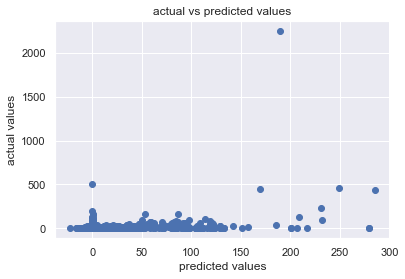

In [31]:
plt.scatter(preds, test_t)
plt.xlabel('predicted values')
plt.ylabel('actual values')
plt.title('actual vs predicted values')
plt.show()

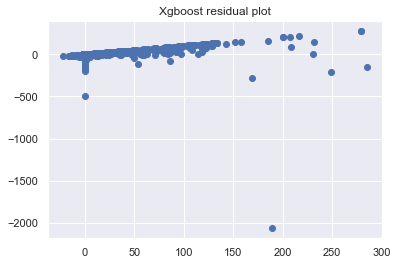

In [32]:
xgb_residual = preds - test_t
plt.scatter(preds, xgb_residual)
plt.title('Xgboost residual plot')
plt.show()

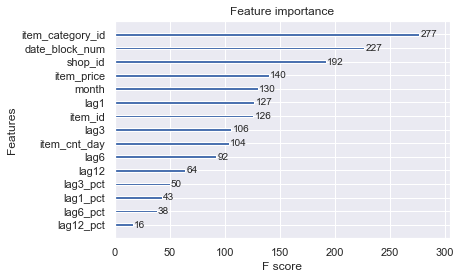

In [33]:
from xgboost import plot_importance
plot_importance(xg_reg)
plt.show()

In [34]:
rfc = RandomForestRegressor(n_estimators=250, max_depth=6, n_jobs=-1, min_samples_leaf=1000)

In [35]:
%%time
rfc.fit(train_f, train_t);

Wall time: 20min 29s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=6, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1000,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=250, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [36]:
pred_rfc = rfc.predict(test_f)
rmse_rfc = np.sqrt(mean_squared_error(test_t,pred_rfc))
print("RMSE: %f" % (rmse_rfc))

RMSE: 3.851164


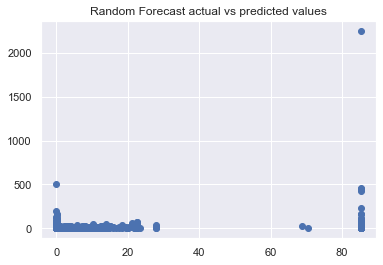

In [37]:
plt.scatter(pred_rfc, test_t)
plt.title('Random Forecast actual vs predicted values')
plt.show()

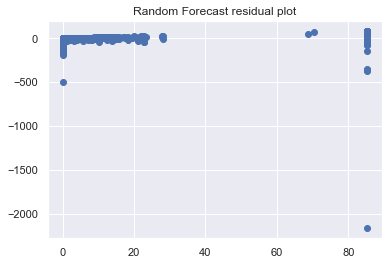

In [38]:
rfc_residual = pred_rfc - test_t
plt.scatter(pred_rfc, rfc_residual)
plt.title('Random Forecast residual plot')
plt.show()

Wall time: 172 ms


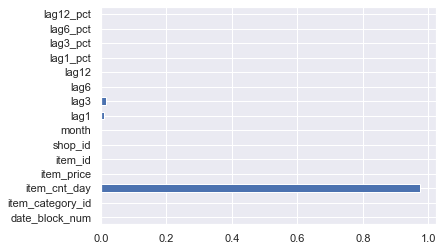

In [39]:
%%time
f_importance = pd.Series(rfc.feature_importances_, index=train_f.columns)
f_importance.plot(kind='barh')

In [40]:
regr = linear_model.Ridge()
regr.fit(train_f, train_t)
pred_reg = regr.predict(test_f)
rmse_reg = np.sqrt(mean_squared_error(test_t, pred_reg))
print("RMSE: %f" % (rmse_reg))

RMSE: 4.031608


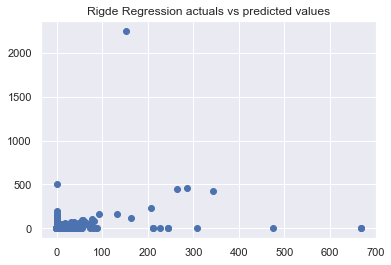

In [41]:
plt.scatter(pred_reg, test_t)
plt.title('Rigde Regression actuals vs predicted values')
plt.show()

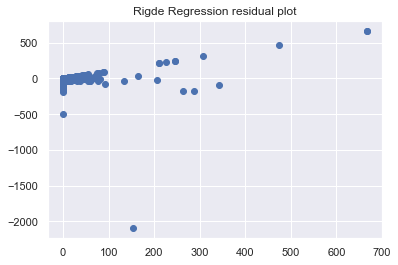

In [42]:
reg_residual = pred_reg - test_t
plt.scatter(pred_reg, reg_residual)
plt.title('Rigde Regression residual plot')
plt.show()

In [43]:
model_comparison = dict({'xgb': rmse_xgb, 'random_forest': rmse_rfc, 'ridge': rmse_reg})
print(model_comparison)

{'xgb': 3.9147209995668977, 'random_forest': 3.851164370252586, 'ridge': 4.031607779752055}


##### All three models have close performance. Xgboost executed faster and become the preferred model.

In [44]:
# save the final df for ease of access in other works
# final_df.to_csv('data/final_df.csv', index=True)